# Gyro bias stability trending

This notebook presents trending plots related to the stability of the gyro bias over a 30-minute timescale.

The key metric is the $\Delta$-bias, defined as the change in pitch / yaw gyro bias over 30 minutes.  This gives a good estimate of bias excursions on a timescale that is important for inducing maneuver errors.  The integrated bias error (in arcsec) over 30 minutes was also investigated but gives qualitatively similar results.

Tracking  the long-term bias *RMS variations* has no direct bearing on maneuver errors since one can see large RMS variations due to slow changes over many hours.  These slow changes do not result in large maneuver errors.

The roll bias is not considered here because that is strongly influenced by issues in ACA centroiding (e.g. tracking warm pixels) and thus does not cleanly reflect gyro behavior.

The primary dataset used for this analysis is a database of gyro-bias values taken at 1-minute intervals since 2010.  Only intervals within a Kalman dwell (as defined by the kadi `dwell` event) are used.  Within each interval the median gyro bias (`AOGBIAS<N>`) is recorded.  Note that the dwell intervals used here are taken to start 20 minutes after the Kalman filter starts so the gyro bias estimate is converged.  This misses some gyro bias excursions that happen during a manuever, but the bias behavior may be different during that time.

In [1]:
from Ska.Matplotlib import plot_cxctime, cxctime2plotdate
from Ska.Numpy import interpolate
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from Chandra.Time import DateTime
from Ska.engarchive import fetch_eng as fetch
from Ska.engarchive.utils import logical_intervals
from kadi import events

import shelve
%matplotlib inline

In [2]:
R2A = np.degrees(1) * 3600

In [3]:
# Read all the dwells into memory
biases = dict(shelve.open('biases4.shelve', protocol=-1).items())

In [4]:
def bias_variability(bias, delta_mins=30, integrate=True):
    """
    Get running estimate of bias variability, either as a difference between
    samples separated by ``delta_mins`` (integrate=False) or as the integral
    of ``delta_mins`` of samples (after subtracting the value of the first
    sample in the span).

    :param bias: 3 x N array of bias values [arcsec/sec] sampled at 1 minute intervals
    :param delta_mins: difference or integration interval [minutes]
    :param integrate: perform difference or integration

    :returns: bias variability (3 x N array), either arcsec/sec (integrate=False) or arcsec
    """

    # Integrate between x0, x1 of (y - y(t0)) = Int(y) - (t1-t0) * y(t0)
    # dt = 1 (minute) here, but bias is arcsec/sec, so mult by 60 later
    # to get arcsec.
    if integrate:
        bias_sum = np.cumsum(bias, axis=1)
        bias_sum_var = (bias_sum[:, delta_mins:] - bias_sum[:, :-delta_mins] 
                        - delta_mins * bias[:, :-delta_mins])
        bias_var = bias_sum_var * 60
    else:
        bias_var = bias[:, delta_mins:] - bias[:, :-delta_mins]

    return bias_var

In [5]:
def get_jog_events(times_list, bias_vars_list, jog_limit, delta_mins=30):
    jogs = {1: [], 2: []}

    for times, bias_vars in zip(times_list, bias_vars_list):
        for idx in (1, 2):  # Gyro pitch, yaw respectively
            within_jog = np.abs(bias_vars[idx]) > jog_limit
            if np.any(within_jog):
                tbl = logical_intervals(times, within_jog, complete_intervals=False)
                jogs[idx].append(tbl)
                
    for idx in (1, 2):
        ji = jogs[idx] = vstack(jogs[idx])
        ji['duration'] += delta_mins * 60  # add in the 30 minute delta interval
        ji['tstop'] += delta_mins * 60
        ji['datestop'] = DateTime(ji['tstop']).date
        
    return jogs

In [6]:
def get_bias_vars_times(biases, integrate=False, delta_mins=30, unique_times=False, start='1999:001',
                        jog_limit=0.03):
    datestart = DateTime(start).date
    biases = {date: val for date, val in biases.items() if date > datestart}
    bias_vars_list = [bias_variability(bias, integrate=integrate, delta_mins=delta_mins) 
                      for bias in biases.values()]
    bias_vars = np.hstack(bias_vars_list)

    times = DateTime(biases.keys()).secs
    unique_times_list = []
    same_times_list = []
    for time, bias_var in zip(times, bias_vars_list):
        unique_ts = time + 60 * np.arange(len(bias_var[0]))
        same_ts = np.repeat(time, len(bias_var[0]))  # one time stamp per dwell
        unique_times_list.append(unique_ts)
        same_times_list.append(same_ts)

    times = np.hstack(unique_times_list if unique_times else same_times_list)
    bias_jogs = get_jog_events(unique_times_list, bias_vars_list, jog_limit, delta_mins)
    
    # Add dbias to bias jogs
    times_list = []
    biases_list = []
    keys_list = []
    for key in sorted(biases.keys()):
        time = DateTime(key).secs
        bias = biases[key]
        times_list.append(time + 60 * np.arange(len(bias[0])))
        biases_list.append(bias)
        keys_list.append(key)
    times_all = np.hstack(times_list)
    biases_all = np.hstack(biases_list)
    iarg = np.argsort(times_all)
    times_all = times_all[iarg]
    biases_all[0] = biases_all[0, iarg]
    biases_all[1] = biases_all[1, iarg]
    biases_all[2] = biases_all[2, iarg]
    
    for axis in (1, 2):
        bias_jogs[axis]['dbias'] = 0.0
        for bj in bias_jogs[axis]:
            i0, i1 = np.searchsorted(times_all, [bj['tstart'], bj['tstop']])
            bj['dbias'] = biases_all[axis][i1] - biases_all[axis][i0]

    return bias_vars, times, bias_jogs

In [7]:
# Compute delta-bias over 30-minute values for each interval
bias_vars, bias_times, bias_jogs = get_bias_vars_times(biases, delta_mins=30, 
                                                       unique_times=True, integrate=False,
                                                       jog_limit=0.03
                                                         )

In [8]:
bias_jogs[1]

datestart,datestop,duration,tstart,tstop,dbias
str21,str21,float64,float64,float64,float64
2010:262:01:46:17.188,2010:262:02:21:17.188,2100.0,401248043.372,401250143.372,-0.0345650911331
2016:339:12:37:25.155,2016:339:13:08:25.155,1860.0,597242313.339,597244173.339,0.0306777954102
2017:040:01:54:27.887,2017:040:02:28:27.887,2040.0,602992537.071,602994577.071,0.0319399833679
2017:082:04:13:35.298,2017:082:05:15:35.298,3720.0,606629684.482,606633404.482,0.0640835762024
2016:301:07:25:24.862,2016:301:08:05:24.862,2400.0,593940393.046,593942793.046,-0.0324196815491


In [9]:
# Put into a table and assign an integer "day" number (days since 1998.0)
t = Table([bias_times, bias_vars[1], bias_vars[2]], names=['time', 'dbias_pitch', 'dbias_yaw'])
t['day'] = t['time'] // (60 * 60 * 24)
tg = t.group_by('day')

In [10]:
# Compute daily max for abs(delta bias) in each axis
ngrp = len(tg.groups)
tga = dict()
for axis in ('pitch', 'yaw'):
    db = 'dbias_{}'.format(axis)
    tga[axis] = Table([np.zeros(ngrp), np.zeros(ngrp)], names=['time', 'dbias'])
    for ii, grp in enumerate(tg.groups):
        vals = np.abs(grp[db])
        jj = np.argmax(vals)
        tga[axis]['time'][ii] = grp['time'][jj]
        tga[axis]['dbias'][ii] = vals[jj]        

In [11]:
# Plot daily maxes and capture big bias jogs (> 0.03 arcsec/sec)
def plot_daily_maxes(tga, start='2000:001', stop=None):
    tstart = DateTime(start).secs
    tstop = DateTime(stop).secs
    
    plt.figure(figsize=(8, 4))
    bigs = []

    for axis, marker in (('pitch', 'b.'), ('yaw', 'r.')):
        tgaa = tga[axis]
        ok = (tgaa['time'] >= tstart) & (tgaa['time'] < tstop)
        tgaa = tgaa[ok]
        plot_cxctime(tgaa['time'], tgaa['dbias'], marker, alpha=0.5, label=axis)
        idxs = np.where(tgaa['dbias'] > 0.03)[0]
        if len(idxs) > 0:
            for ii in idxs:
                bigs.append((axis, ii))

    plt.grid();
    plt.ylabel('arcsec / sec')
    plt.margins(0.05);
    tstart, tstop = np.min(tgaa['time']), np.max(tgaa['time'])
    y0, y1 = plt.ylim()
    evts = events.safe_suns.filter(tstart, tstop)
    for evt in evts:
        plot_cxctime([evt.tstart, evt.tstart], [y0, y1], '-g', lw=1.5, alpha=0.5)
        plt.text(s='Safe mode', x=cxctime2plotdate([evt.tstart])[0], y=0.03, rotation='vertical')
        
    plt.legend(loc='upper left', fancybox=True, framealpha=0.5, numpoints=1, fontsize='medium')
    plt.title('Daily max $\Delta$-bias over 30 minutes')
    
    return bigs

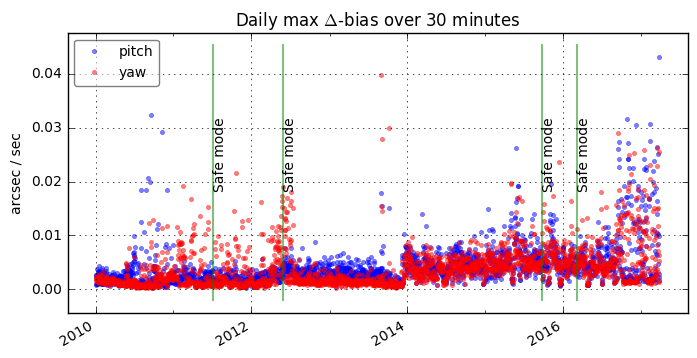

In [12]:
bigs = plot_daily_maxes(tga)

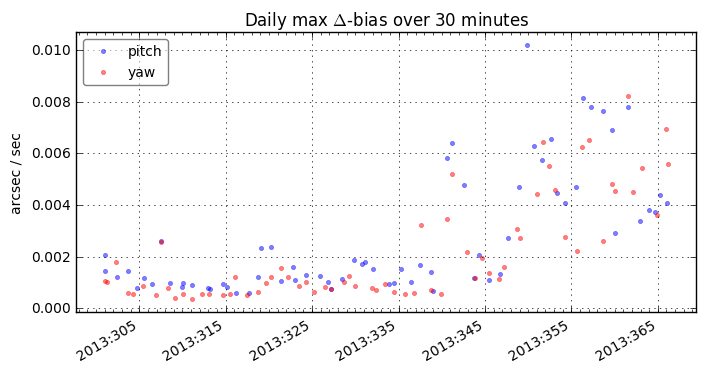

In [13]:
plot_daily_maxes(tga, '2013:300', '2014:001');

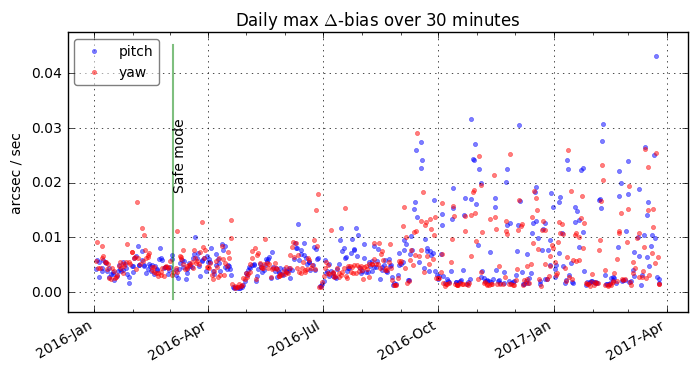

In [14]:
plot_daily_maxes(tga, '2016:001');

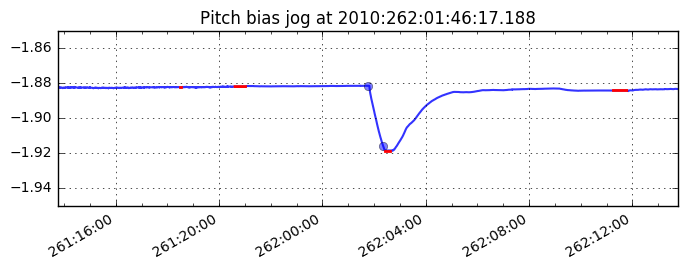

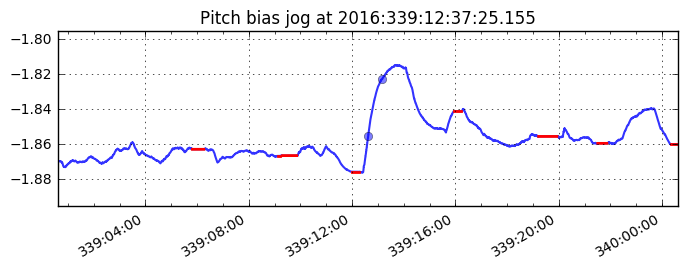

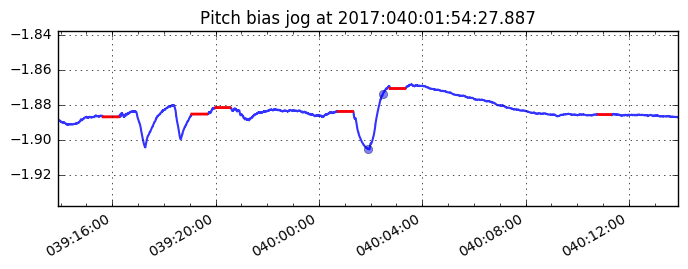

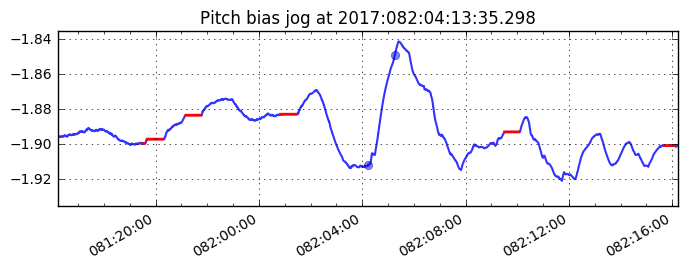

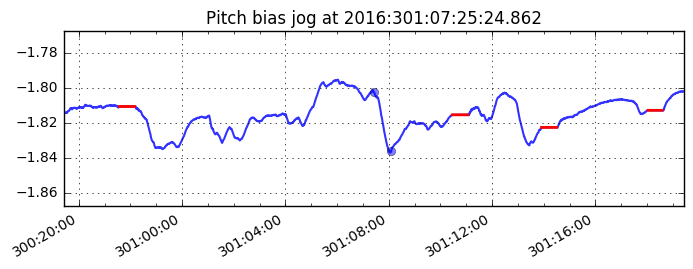

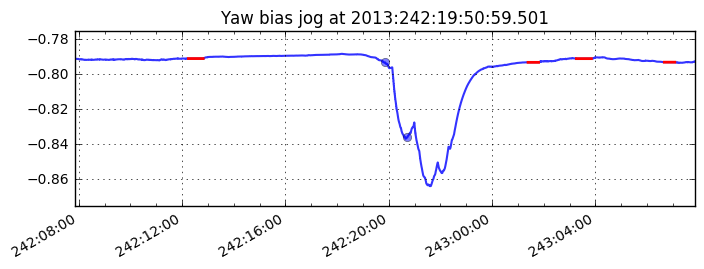

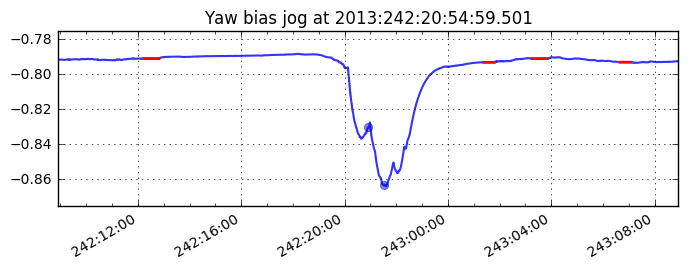

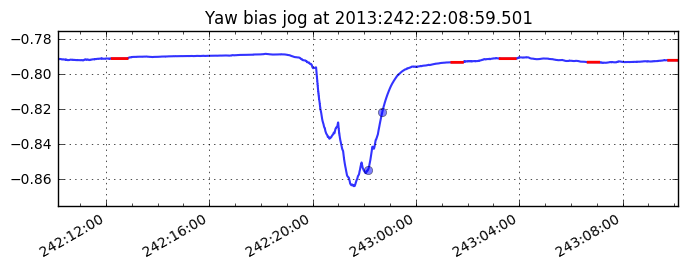

In [15]:
# Plot the big bias jogs (delta-bias > 0.03) to make sure they are reasonable
labels = {1: 'Pitch', 2: 'Yaw'}
for naxis in (1, 2):
    for bj in bias_jogs[naxis]:
        tm = bj['tstart']
        tstart = tm - 43200
        tstop = tm + 43200
        dat = fetch.Msid('aogbias{}'.format(naxis + 1), tm - 43200, tm + 43200)
        plt.figure(figsize=(8 ,2.5))
        vals = dat.vals * R2A
        i0, i1 = np.searchsorted(dat.times, [bj['tstart'], bj['tstop']])
        ts = dat.times[[i0, i1]]
        vs = vals[[i0, i1]]
        plot_cxctime(dat.times, dat.vals * R2A, lw=1.5, alpha=0.8)
        plot_cxctime(ts, vs, 'o', alpha=0.5)
        manvrs = events.manvrs.filter(tstart, tstop)
        for manvr in manvrs:
            i0, i1 = np.searchsorted(dat.times, [manvr.tstart, manvr.tstop])
            plot_cxctime(dat.times[i0:i1], dat.vals[i0:i1] * R2A, '-r', lw=2)
        y0, y1 = plt.ylim()
        ym = np.mean([y0, y1])
        plt.ylim(ym - 0.05, ym + 0.05)  # Replicate daily plot y-range
        plt.title('{} bias jog at {}'.format(labels[naxis], DateTime(tm).date))
        plt.grid();

In [16]:
# Compute delta-bias over 30-minute values for each interval
*args, bias_jogs001 = get_bias_vars_times(biases, delta_mins=30, 
                                                       unique_times=True, integrate=False,
                                                       jog_limit=0.01
                                                         )

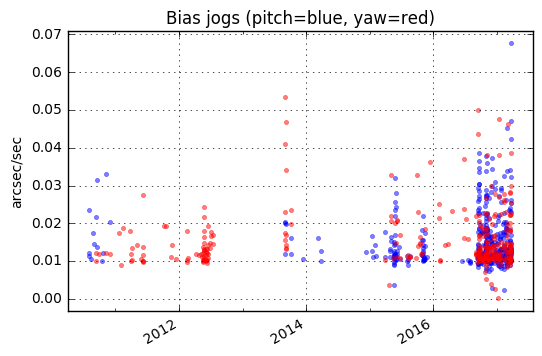

In [17]:
plot_cxctime(bias_jogs001[1]['tstart'], np.abs(bias_jogs001[1]['dbias']), '.b', alpha=0.5);
plot_cxctime(bias_jogs001[2]['tstart'], np.abs(bias_jogs001[2]['dbias']), '.r', alpha=0.5);
plt.margins(0.05)
plt.ylabel('arcsec/sec')
plt.title('Bias jogs (pitch=blue, yaw=red)')
plt.grid();

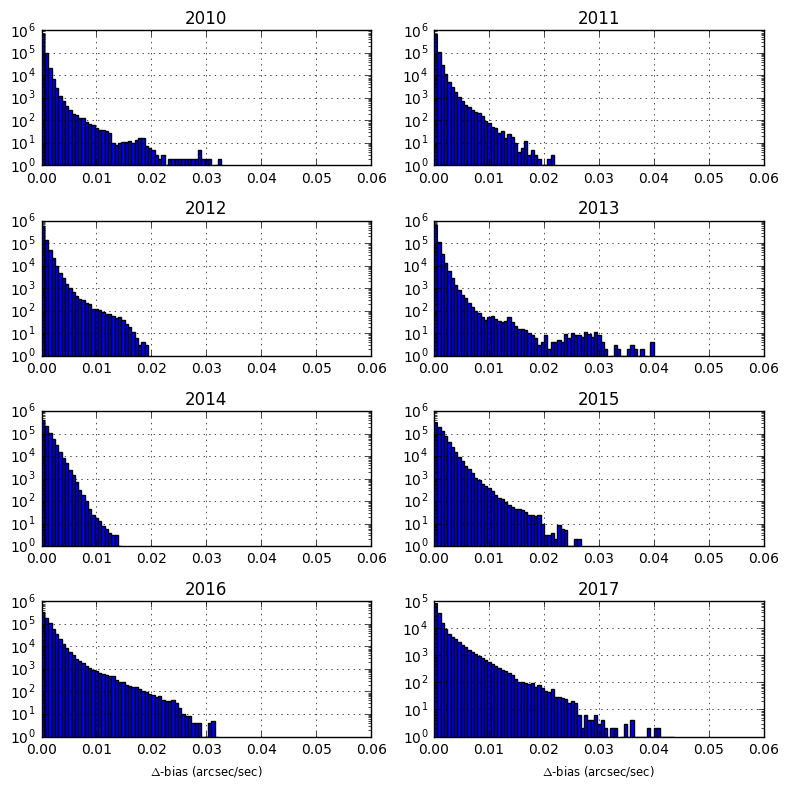

In [18]:
# Plot histogram of delta biases for each year
bins = np.linspace(0, 0.06, 100)
plt.figure(figsize=(8, 8))
for ii, year in enumerate(range(2010, 2018)):
    plt.subplot(4, 2, ii + 1)
    date0 = DateTime('{}:182'.format(year))
    ok = (bias_times > (date0 - 182).secs) & (bias_times < (date0 + 182).secs)
    py = np.concatenate([bias_vars[1][ok], bias_vars[2][ok]])
    plt.hist(np.abs(py), log=True, bins=bins);    
    plt.grid()
    plt.title('{}'.format(year))
    if ii >= 6:
        plt.xlabel('$\Delta$-bias (arcsec/sec)', fontsize='small')
plt.tight_layout()